In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas
from pandas.tools.plotting import autocorrelation_plot
import itertools
import time
import sys
from datetime import datetime

def tri_data(numbers):
    tri_data = np.zeros(numbers, dtype=np.int8)
    tri_data[np.arange(3)] = np.random.choice(np.arange(1,4), 2)
    #tri_data[np.arange(3)] = [1, 2, 3]
    for n in np.arange(3, numbers):
        if tri_data[n-2] == 1:
            tri_data[n] = np.random.choice(np.arange(1,4), p = (0.99, 0.005, 0.005))
        if tri_data[n-2] == 2:
            tri_data[n] = np.random.choice(np.arange(1,4), p = (0.005, 0.99, 0.005))
        else:
            tri_data[n] = np.random.choice(np.arange(1,4), p = (0.005, 0.005, 0.99))
    return(tri_data)
data = tri_data(200)
data

C:\Users\Allainware\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


array([2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3], dtype=int8)

In [3]:
start_time = datetime.now()
#simulating for S times
S = 20000
L = 100
alpha0 = 1

# generate z1t, z2t, z3t... according to the corresponding k1, k2, k3, ...
k1 = np.zeros(S)
k2 = np.zeros(S)
k3 = np.zeros(S)
k1[0] = 2
k2[0] = 2
k3[0] = 2
z_j_t = np.zeros((3, len(data), S))
z_j_t[:,:,0] = 1
C0 = 3
alpha = 1/C0
q = 3
eta = 0.5
gamma1 = gamma2 = gamma3 = 1/C0


#step 1
#define pi_ast_l
pi_ast_l = np.zeros(L)
V_l = np.random.beta(1, alpha0, L)
pi_ast_l[0] = V_l[0]
oneminusV_l = 1 - V_l 
for n in np.arange(1, L):
    pi_ast_l[n] = V_l[n]*np.prod(oneminusV_l[:n])   
    
lambda_ast_l = np.random.dirichlet(np.repeat(1/C0, C0), L)

def nh1h2h3y(h1, h2, h3, y):
    case1 = (z_j_t[0, q:, 0] == h1)*1
    case2 = (z_j_t[1, q:, 0] == h2)*1 
    case3 = (z_j_t[2, q:, 0] == h3)*1
    case123 = case1*case2*case3
    case4 = (data[q:] == y)*1
    nh1h2h3y = np.sum(case123*case4)
    return(nh1h2h3y)

#simulating l, PLN()[l-1] means the prob of l with h1, h2, h3
def PLN(h1, h2, h3):
    lamny = [(lambda_ast_l[:, y-1]**nh1h2h3y(h1, h2, h3, y)) for y in range(1, C0+1)]
    PLNnotnorm = pi_ast_l*np.prod(lamny, axis = 0)
    PLN = PLNnotnorm/np.sum(PLNnotnorm)
    return PLN

def sample_z_ast(h1, h2, h3):
    z = np.random.choice(np.arange(1, L+1), p = PLN(h1, h2, h3))
    return z
h1 = np.arange(1, k1[0]+1)
h2 = np.arange(1, k2[0]+1)
h3 = np.arange(1, k3[0]+1)
per = list(itertools.product(h1,h2, h3)) #permutations
zz = list(map(lambda x: sample_z_ast(*x), per))
z_ast_h1h2h3 = np.reshape(zz, (k1[0],k2[0],k3[0]))

#step 2
def sample_V_l(l): 
    return np.random.beta(1 + np.count_nonzero(z_ast_h1h2h3 == l), alpha0 + np.count_nonzero(z_ast_h1h2h3 > l), 1).tolist()
V_l = np.concatenate(list(map(lambda x: sample_V_l(x), range(1, L+1))))
pi_ast_l[0] = V_l[0]
oneminusV_l = 1 - V_l 
for n in np.arange(1, L):
    pi_ast_l[n] = V_l[n]*np.prod(oneminusV_l[:n])


#step 3
def n_ast_l_y(l, y):
    def nnn(h1, h2, h3):
        nnn = np.count_nonzero(z_ast_h1h2h3[h1-1, h2-1, h3-1] == l)*nh1h2h3y(h1, h2, h3, y)
        return nnn
    h1 = np.arange(1, k1[0]+1)
    h2 = np.arange(1, k2[0]+1)
    h3 = np.arange(1, k3[0]+1)
    per = list(itertools.product(h1,h2, h3))
    nn = list(map(lambda x: nnn(*x), per))
    #return per
    n_ast_l_y = np.sum(nn)
    return(n_ast_l_y)

#lambda_ast_l[l-1, y-1] means the value of (l,y)
def nrd(l):
    nrd = np.random.dirichlet([1/C0 + n_ast_l_y(l, y) for y in np.arange(1, C0+1)])
    return nrd
lambda_ast_l = np.array(list(map(lambda x: nrd(x), np.arange(1, L+1))))

#step 4
#def n_j_wj_hj(j, wj, hj):
#    n_j_wj_hj = sum([1 if z_j_t[j-1,t,0] == hj and data[t-j] == wj else 0 for t in range(q, len(data))])
#    return n_j_wj_hj

def n_j_wj_hj(j, wj, hj):
    case1 = (z_j_t[j-1, np.arange(q, len(data)),0] == hj)*1
    case2 = (data[np.arange(q, len(data))-j] == wj)*1
    n_j_wj_hj = np.sum(case1*case2)
    return(n_j_wj_hj)


pi_1_w1 = np.zeros((C0, k1[0]))
for c in np.arange(C0):
        pi_1_w1[c, :] = np.random.dirichlet([1/C0 + n_j_wj_hj(1, c+1, h1) for h1 in np.arange(1, k1[0]+1)])
        
pi_2_w2 = np.zeros((C0, k2[0]))
for c in np.arange(C0):
        pi_2_w2[c, :] = np.random.dirichlet([1/C0 + n_j_wj_hj(2, c+1, h2) for h2 in np.arange(1, k2[0]+1)])
        
pi_3_w3 = np.zeros((C0, k3[0]))
for c in np.arange(C0):
        pi_3_w3[c, :] = np.random.dirichlet([1/C0 + n_j_wj_hj(3, c+1, h3) for h3 in np.arange(1, k3[0]+1)])
        
#step 5
t = np.arange(q, len(data))

PWLZY_1 = np.zeros((k1[0], len(data)))
for h in np.arange(k1[0]):
    PWLZY_1[h,t] = pi_1_w1[data[t-1]-1, h]*lambda_ast_l[z_ast_h1h2h3[h, np.array(z_j_t[1,t,0], dtype = np.int8)-1, np.array(z_j_t[2,t,0], dtype = np.int8)-1]-1, data[t]-1]
PWLZY_1[:,t] = PWLZY_1[:,t]/np.sum(PWLZY_1[:,t], axis = 0)
        
PWLZY_2 = np.zeros((k2[0], len(data)))
for h in np.arange(k2[0]):
    PWLZY_2[h,t] = pi_2_w2[data[t-2]-1, h]*lambda_ast_l[z_ast_h1h2h3[np.array(z_j_t[0,t,0], dtype = np.int8)-1, h, np.array(z_j_t[2,t,0], dtype = np.int8)-1]-1, data[t]-1]
PWLZY_2[:,t] = PWLZY_2[:,t]/np.sum(PWLZY_2[:,t], axis = 0)
        
PWLZY_3 = np.zeros((k3[0], len(data)))
for h in np.arange(k3[0]):
    PWLZY_3[h,t] = pi_3_w3[data[t-3]-1, h]*lambda_ast_l[z_ast_h1h2h3[np.array(z_j_t[0,t,0], dtype = np.int8)-1, np.array(z_j_t[1,t,0], dtype = np.int8)-1, h]-1, data[t]-1]
PWLZY_3[:,t] = PWLZY_3[:,t]/np.sum(PWLZY_3[:,t], axis = 0)
    
pp1 = PWLZY_1[:,np.arange(q, len(data))].transpose()
c1 = pp1.cumsum(axis=1)
u1 = np.random.rand(len(c1), 1)
z_j_t[0,q:,1] = (u1 < c1).argmax(axis=1)+1

pp2 = PWLZY_2[:,np.arange(q, len(data))].transpose()
c2 = pp2.cumsum(axis=1)
u2 = np.random.rand(len(c2), 1)
z_j_t[1,q:,1] = (u2 < c2).argmax(axis=1)+1

pp3 = PWLZY_3[:,np.arange(q, len(data))].transpose()
c3 = pp3.cumsum(axis=1)
u3 = np.random.rand(len(c3), 1)
z_j_t[2,q:,1] = (u3 < c3).argmax(axis=1)+1

#print(z_j_t[:,:,1])

#step 6
p_k1 = np.zeros(C0)
for i in np.arange(max(z_j_t[0, :, 1])-1, C0):
    p_k1[i] = np.exp(-eta*1*(i+1))*np.prod([math.gamma((i+1)*gamma1)/(math.gamma((i+1)*gamma1 + 
              list(data[(q-1):(len(data)-1)]).count(r))) for r in np.arange(1, C0+1)])
p1 = p_k1/np.sum(p_k1)
k1[1] = np.random.choice(np.arange(1, C0+1), p = p1)

p_k2 = np.zeros(C0)
for i in np.arange(max(z_j_t[1, :, 1])-1, C0):
    p_k2[i] = np.exp(-eta*2*(i+1))*np.prod([math.gamma((i+1)*gamma2)/(math.gamma((i+1)*gamma2 + 
              list(data[(q-2):(len(data)-2)]).count(r))) for r in np.arange(1, C0+1)])
p2 = p_k2/np.sum(p_k2)
k2[1] = np.random.choice(np.arange(1, C0+1), p = p2)


p_k3 = np.zeros(C0)
for i in np.arange(max(z_j_t[2, :, 1])-1, C0):
    p_k3[i] = np.exp(-eta*3*(i+1))*np.prod([math.gamma((i+1)*gamma3)/(math.gamma((i+1)*gamma3 + 
              list(data[(q-3):(len(data)-3)]).count(r))) for r in np.arange(1, C0+1)])
p3 = p_k3/np.sum(p_k3)
k3[1] = np.random.choice(range(1, C0+1), p = p3)

##Additional step, predict y
y_pp = np.zeros((len(t), S))
tt =z_ast_h1h2h3[np.array(z_j_t[0,q:,1], dtype = np.int8)-1, np.array(z_j_t[1,q:,1], dtype = np.int8)-1, np.array(z_j_t[2,q:,1], dtype = np.int8)-1]-1
ltt = lambda_ast_l[tt, :]
cltt = ltt.cumsum(axis=1)
ultt = np.random.rand(len(cltt), 1)
y_pred = (ultt < cltt).argmax(axis=1)+1
y_pp[:,0] = y_pred

for s in np.arange(1, S-1):
#step 1
    def nh1h2h3y(h1, h2, h3, y):
        case1 = (z_j_t[0, q:, s] == h1)*1
        case2 = (z_j_t[1, q:, s] == h2)*1 
        case3 = (z_j_t[2, q:, s] == h3)*1
        case123 = case1*case2*case3
        case4 = (data[q:] == y)*1
        nh1h2h3y = np.sum(case123*case4)
        return(nh1h2h3y)

    def PLN(h1, h2, h3):
        lamny = [(lambda_ast_l[:, y-1]**nh1h2h3y(h1, h2, h3, y)) for y in range(1, C0+1)]
        PLNnotnorm = pi_ast_l*np.prod(lamny, axis = 0)
        PLN = PLNnotnorm/np.sum(PLNnotnorm)
        return PLN

    def sample_z_ast(h1, h2, h3):
        z = np.random.choice(np.arange(1, L+1), p = PLN(h1, h2, h3))
        return z
    h1 = np.arange(1, k1[s]+1)
    h2 = np.arange(1, k2[s]+1)
    h3 = np.arange(1, k3[s]+1)
    per = list(itertools.product(h1,h2, h3)) #permutations
    zz = list(map(lambda x: sample_z_ast(*x), per))
    z_ast_h1h2h3 = np.reshape(zz, (k1[s],k2[s],k3[s]))

#step 2
    def sample_V_l(l): 
        return np.random.beta(1 + np.count_nonzero(z_ast_h1h2h3 == l), alpha0 + np.count_nonzero(z_ast_h1h2h3 > l), 1).tolist()
    V_l = np.concatenate(list(map(lambda x: sample_V_l(x), range(1, L+1))))
    pi_ast_l[0] = V_l[0]
    oneminusV_l = 1 - V_l 
    for n in np.arange(1, L):
        pi_ast_l[n] = V_l[n]*np.prod(oneminusV_l[:n])
        
#step 3
    def n_ast_l_y(l, y):
        def nnn(h1, h2, h3):
            nnn = np.count_nonzero(z_ast_h1h2h3[h1-1, h2-1, h3-1] == l)*nh1h2h3y(h1, h2, h3, y)
            return nnn
        h1 = np.arange(1, k1[s]+1)
        h2 = np.arange(1, k2[s]+1)
        h3 = np.arange(1, k3[s]+1)
        per = list(itertools.product(h1,h2, h3))
        nn = list(map(lambda x: nnn(*x), per))
        #return per
        n_ast_l_y = np.sum(nn)
        return(n_ast_l_y)
        
    def nrd(l):
        nrd = np.random.dirichlet([1/C0 + n_ast_l_y(l, y) for y in np.arange(1, C0+1)])
        return nrd
    lambda_ast_l = np.array(list(map(lambda x: nrd(x), np.arange(1, L+1))))
    
#step 4    
    def n_j_wj_hj(j, wj, hj):
        case1 = (z_j_t[j-1, np.arange(q, len(data)),s] == hj)*1
        case2 = (data[np.arange(q, len(data))-j] == wj)*1
        n_j_wj_hj = np.sum(case1*case2)
        return(n_j_wj_hj)
    
    pi_1_w1 = np.zeros((C0, k1[s]))
    for c in np.arange(C0):
        pi_1_w1[c, :] = np.random.dirichlet([1/C0 + n_j_wj_hj(1, c+1, h1) for h1 in np.arange(1, k1[s]+1)])

    pi_2_w2 = np.zeros((C0, k2[s]))
    for c in np.arange(C0):
        pi_2_w2[c, :] = np.random.dirichlet([1/C0 + n_j_wj_hj(2, c+1, h2) for h2 in np.arange(1, k2[s]+1)])
        
    pi_3_w3 = np.zeros((C0, k3[s]))
    for c in np.arange(C0):
        pi_3_w3[c, :] = np.random.dirichlet([1/C0 + n_j_wj_hj(3, c+1, h3) for h3 in np.arange(1, k3[s]+1)])

#step 5
    PWLZY_1 = np.zeros((k1[s], len(data)))
    for h in np.arange(k1[s]):
        PWLZY_1[h,t] = pi_1_w1[data[t-1]-1, h]*lambda_ast_l[z_ast_h1h2h3[h, np.array(z_j_t[1,t,s], dtype = np.int8)-1, np.array(z_j_t[2,t,s], dtype = np.int8)-1]-1, data[t]-1]
    PWLZY_1[:,t] = PWLZY_1[:,t]/np.sum(PWLZY_1[:,t], axis = 0)
        
    PWLZY_2 = np.zeros((k2[s], len(data)))
    for h in np.arange(k2[s]):
        PWLZY_2[h,t] = pi_2_w2[data[t-2]-1, h]*lambda_ast_l[z_ast_h1h2h3[np.array(z_j_t[0,t,s], dtype = np.int8)-1, h, np.array(z_j_t[2,t,s], dtype = np.int8)-1]-1, data[t]-1]
    PWLZY_2[:,t] = PWLZY_2[:,t]/np.sum(PWLZY_2[:,t], axis = 0)
        
    PWLZY_3 = np.zeros((k3[s], len(data)))
    for h in np.arange(k3[s]):
        PWLZY_3[h,t] = pi_3_w3[data[t-3]-1, h]*lambda_ast_l[z_ast_h1h2h3[np.array(z_j_t[0,t,s], dtype = np.int8)-1, np.array(z_j_t[1,t,s], dtype = np.int8)-1, h]-1, data[t]-1]
    PWLZY_3[:,t] = PWLZY_3[:,t]/np.sum(PWLZY_3[:,t], axis = 0)
    
    pp1 = PWLZY_1[:,np.arange(q, len(data))].transpose()
    c1 = pp1.cumsum(axis=1)
    u1 = np.random.rand(len(c1), 1)
    z_j_t[0,q:,s+1] = (u1 < c1).argmax(axis=1)+1

    pp2 = PWLZY_2[:,np.arange(q, len(data))].transpose()
    c2 = pp2.cumsum(axis=1)
    u2 = np.random.rand(len(c2), 1)
    z_j_t[1,q:,s+1] = (u2 < c2).argmax(axis=1)+1

    pp3 = PWLZY_3[:,np.arange(q, len(data))].transpose()
    c3 = pp3.cumsum(axis=1)
    u3 = np.random.rand(len(c3), 1)
    z_j_t[2,q:,s+1] = (u3 < c3).argmax(axis=1)+1
        
#step 6
    p_k1 = np.zeros(C0)
    for i in np.arange(max(z_j_t[0, :, s+1])-1, C0):
        p_k1[i] = np.exp(-eta*1*(i+1))*np.prod([math.gamma((i+1)*gamma1)/(math.gamma((i+1)*gamma1 + 
                  list(data[(q-1):(len(data)-1)]).count(r))) for r in np.arange(1, C0+1)])
    p1 = p_k1/np.sum(p_k1)
    k1[s+1] = np.random.choice(np.arange(1, C0+1), p = p1)

    p_k2 = np.zeros(C0)
    for i in np.arange(max(z_j_t[1, :, s+1])-1, C0):
        p_k2[i] = np.exp(-eta*2*(i+1))*np.prod([math.gamma((i+1)*gamma2)/(math.gamma((i+1)*gamma2 + 
                  list(data[(q-2):(len(data)-2)]).count(r))) for r in np.arange(1, C0+1)])
    p2 = p_k2/np.sum(p_k2)
    k2[s+1] = np.random.choice(np.arange(1, C0+1), p = p2)


    p_k3 = np.zeros(C0)
    for i in np.arange(max(z_j_t[2, :, s+1])-1, C0):
        p_k3[i] = np.exp(-eta*3*(i+1))*np.prod([math.gamma((i+1)*gamma3)/(math.gamma((i+1)*gamma3 + 
                  list(data[(q-3):(len(data)-3)]).count(r))) for r in np.arange(1, C0+1)])
    p3 = p_k3/np.sum(p_k3)
    k3[s+1] = np.random.choice(range(1, C0+1), p = p3)

#additional step
    tt = z_ast_h1h2h3[np.array(z_j_t[0,q:,s+1], dtype = np.int8)-1, np.array(z_j_t[1,q:,s+1], dtype = np.int8)-1, np.array(z_j_t[2,q:,s+1], dtype = np.int8)-1]-1
    ltt = lambda_ast_l[tt, :]
    cltt = ltt.cumsum(axis=1)
    ultt = np.random.rand(len(cltt), 1)
    y_pred = (ultt < cltt).argmax(axis=1)+1
    y_pp[:,s] = y_pred

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

C:\Users\Allainware\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\Allainware\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Allainware\Anaconda3\lib\site-packages\ipykernel\__main__.py:102: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Allainware\Anaconda3\lib\site-packages\ipykernel\__main__.py:106: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Allainware\Anaconda3\lib\site-packages\ipykernel\__main__.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the futu

Duration: 0:12:10.639040


In [11]:
data

array([3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3,
       2, 3, 2, 3, 2, 3, 2, 3], dtype=int8)

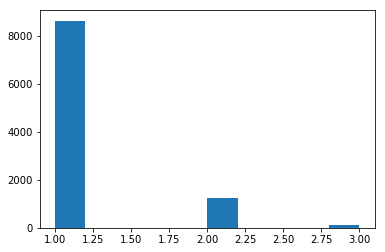

In [6]:
plt.hist(k1[10000:])
plt.show()

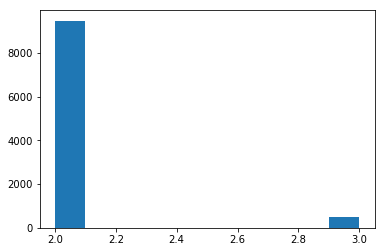

In [8]:
plt.hist(k2[10000:])
plt.show()

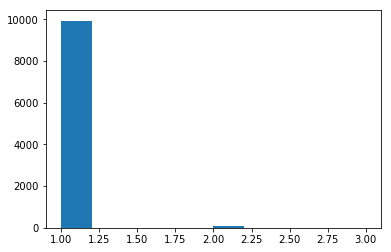

In [9]:
plt.hist(k3[10000:])
plt.show()

In [7]:
y_pp[:,S-2]

array([ 2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,
        3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,
        2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,
        3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,
        2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,
        3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,  2.,  3.,
        2.,  3.,  2.,  3.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  3.,
        2.,  3.,  2.,  3.,  2.,  3.])

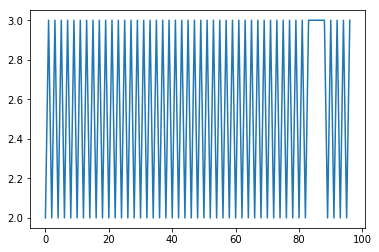

In [10]:
plt.plot(y_pp[:,S-2])
plt.show()